In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_curve, roc_auc_score, confusion_matrix
import shap

# Load the first dataset
oasis_filtered_1 = pd.read_csv('./oasis_filtered_1.csv')

# Display the first few rows of the dataset
oasis_filtered_1.head()

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


,ID,M/F,Hand,Age,Educ,SES,MMSE,CDR,Group,Source,Diagnosis
0,OAS1_0001_MR1,0,R,-0.122643,-0.901332,0.508156,0.478191,-0.764869,Nondemented,OASIS-1,0
1,OAS1_0002_MR1,0,R,-2.050225,0.537958,-1.314609,0.478191,-0.764869,Nondemented,OASIS-1,0
2,OAS1_0003_MR1,0,R,-0.224095,0.537958,0.508156,-0.065249,0.560032,Demented,OASIS-1,1
3,OAS1_0010_MR1,1,R,-0.122643,1.257604,-0.403227,0.749911,-0.764869,Nondemented,OASIS-1,0
4,OAS1_0011_MR1,0,R,-2.354580,-0.181687,-0.403227,0.749911,-0.764869,Nondemented,OASIS-1,0


Here are the steps to building the Random Forest classifier


1. Build a Random Forest Classifier with 5-Fold Cross-Validation: Set up a Random Forest classifier inside a cross-validation loop using GridSearchCV to perform hyperparameter tuning. This ensures that we test different combinations of parameters to find the best model.

2. Hyperparameter Tuning: We will tune parameters such as n_estimators (the number of trees in the forest) and max_depth (the maximum levels of each tree) among others which include min_samples_split and min_samples_leaf.

3. Model Evaluation: Using metrics such as accuracy, confusion matrix, and classification report, we'll assess how well our model is performing.

4. Integrate SHAP Values to Interpret the Model: SHAP values will provide insights into how each feature in the dataset is impacting the model's predictions, which is crucial for understanding the decision-making of our model.

5. Visualizing the random forest and the confusion matrix: This will provide visual insights into the model's structure and performance.

In [2]:
# Define features and target
X = oasis_filtered_1[['Age', 'M/F', 'Educ', 'SES', 'MMSE', 'CDR']]
y = oasis_filtered_1['Diagnosis']

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Shape of the datasets
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((486, 6), (122, 6), (486,), (122,))

Let's set up the random forest with GridSearchCV to find the best parameters using cross-validation.

In [3]:
# Setting up parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Setup the grid search
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')

# Fit the model
grid_search.fit(X_train, y_train)

# Best estimator found by GridSearch
best_rf = grid_search.best_estimator_

# Best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_params, best_score

({'max_depth': 5,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 100},
 0.9691142436355985)

The random forest model was trained using 5-fold cross-validation with GridSearchCV to find the optimal parameters. The best parameters for the model are:

- Max Depth: 5 (the maximum levels of each tree)
- Min Samples Leaf: 1 (the minimum number of samples required to be at a leaf node)
- Min Samples Split: 2 (the minimum number of samples required to split an internal node)
- n_estimators: 100 (the number of trees in the forest)

The best accuracy achieved with these parameters on the training data is approximately 96.9%.

# Feature Importance # 

Let's extract and visualize the feature importances from the random forest model we trained. This will help to understand which features have the most influence on the decisions made by the model.

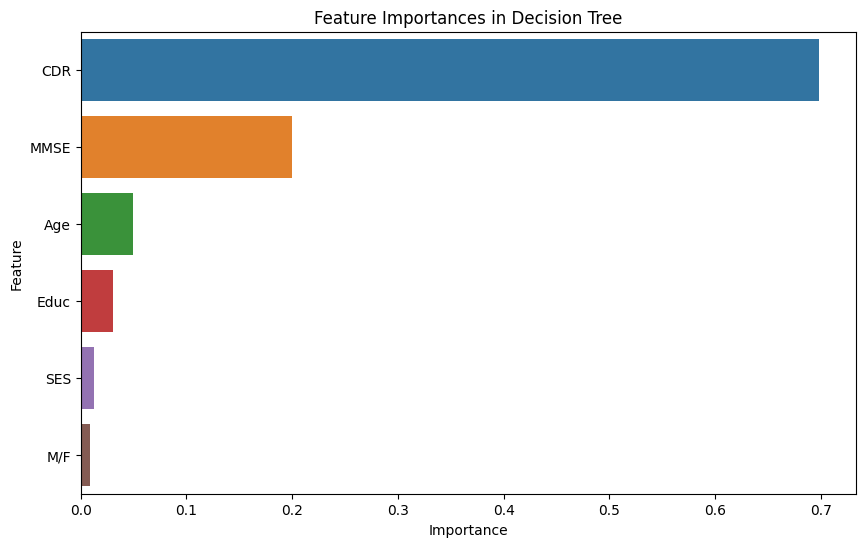

,Feature,Importance
5,CDR,0.698243
4,MMSE,0.199790
0,Age,0.049582
2,Educ,0.030897
3,SES,0.012422
1,M/F,0.009066


In [4]:
# Get feature importances
feature_importances = best_rf.feature_importances_

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances in Decision Tree')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Print the DataFrame for reference
feature_importance_df

The bar chart above displays the relative importance of each feature used by the decision tree model. Here's what we can observe:

- **CDR (Clinical Dementia Rating)**: By far the most significant feature, accounting for about 69.8% of the importance. This suggests that CDR is a crucial indicator for predicting dementia in this dataset.

- **MMSE**: The next most important feature, though much less significant compared to CDR, contributing around 1.2% to the model's decisions.

- **Age, Educ (Education), SES (Socioeconomic Status), and M/F (Gender)**: These features have relatively minor importance in the model.

# Model Evaluation #

Next, we'll evaluate our model using these parameters on the test set. We will also look at other performance metrics like the confusion matrix, classification report and the ROC curve. Let's proceed with this evaluation. 

0.9590163934426229


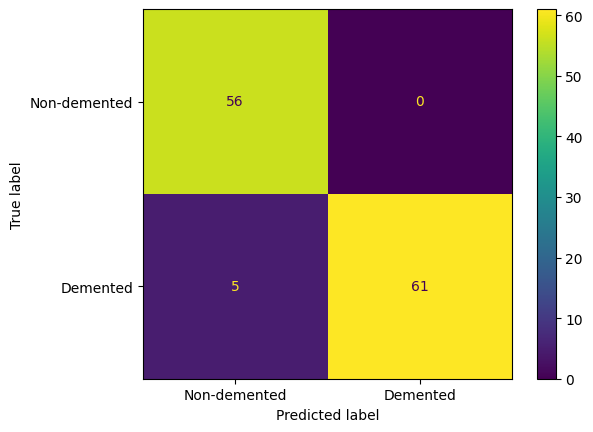

In [5]:
# Use the best parameters to create a new decision tree
best_rf = RandomForestClassifier(max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100, random_state=42)
best_rf.fit(X_train, y_train)

# Predictions on the test set
y_pred = best_rf.predict(X_test)
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]

# Evaluation metrics
class_report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

class_report, conf_matrix

print(accuracy)

# Plotting the confusion matrix
conf_matrix=confusion_matrix(y_test, y_pred)
labels=['Non-demented', 'Demented']
ConfusionMatrixDisplay(conf_matrix, display_labels=labels).plot()

In [6]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        56
           1       1.00      0.92      0.96        66

    accuracy                           0.96       122
   macro avg       0.96      0.96      0.96       122
weighted avg       0.96      0.96      0.96       122



**Model Evaluation Summary**

Here are the performance metrics for our decision tree on the test set:

- **Accuracy**: Approximately 96%, indicating a high level of overall accuracy. 


- **Confusion Matrix**:

- True Negatives (correct non-demented predictions): 56 
- False Positives (non-demented incorrectly labeled as demented): 0 
- False Negatives (demented incorrectly labeled as non-demented): 5 
- True Positives (correct demented predictions): 61 


- **The Classification Report details**:

- **Precision** (correct positive predictions relative to total predicted positives): 
    - Non-demented: 92% 
    - Demented: 100% 
    
- **Recall** (correct positive predictions relative to total actual positives): 
    - Non-demented: 100% 
    - Demented: 92% 
    
- **F1-score**: A balanced measure of precision and recall, showing high values for both classes.

# SHAP Values for Interpretation #

We will break down the prediction to show the impact of each feature and then we'll visualize the SHAP values to help us in understanding how each feature influences the model output.

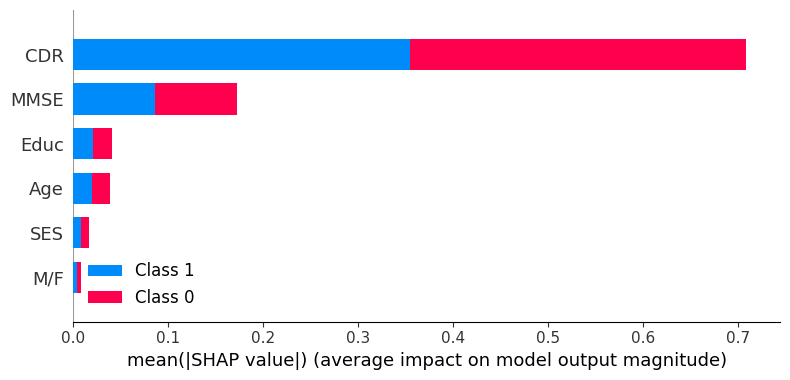

In [7]:
# Calculate SHAP Values to interpret the model
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test)

# Summary plot of SHAP values
shap.summary_plot(shap_values, X_test, plot_type="bar")

SHAP (SHapley Additive exPlanations) summary plots are tools used in machine learning to understand how different features (like age, education, gender) impact the prediction of a model. Let's break down the plots for the Random Forest model separately:


**Understanding the Plot**

1. **Features and Importance**:

- The plot lists several features (like CDR, MMSE, Educ, Age, SES, M/F) along the vertical axis.
- Each feature’s importance in the model is represented by the width of the bar along the horizontal axis. This width is based on the mean (average) SHAP value, which quantifies the impact of each feature on the model's output.

2. **SHAP Values**:

- SHAP values explain the effect of having a certain value for a given feature in comparison to the prediction we'd make if that feature took some baseline value. A higher absolute SHAP value means the feature significantly impacts the model output.
- Positive SHAP values push the prediction more towards one class, and negative SHAP values push it towards another.


**Color Coding and Its Significance**

- **Blue (Class 1 – Demented)**: When features are shown in blue, it means that higher values of these features push the prediction towards Class 1 (demented). For example, if the CDR (Clinical Dementia Rating) is high and it appears blue, it strongly suggests a prediction towards dementia when high.

- **Red (Class 0 – Nondemented)**: Conversely, when features are shown in red, higher values of these features push the prediction towards Class 0 (nondemented). For instance, if the MMSE (Mini-Mental State Examination) score is high and shows up in red, it influences the prediction towards not having dementia.

**Interpretation by Feature**

- **CDR**: A very impactful feature, with high values typically predicting dementia (Class 1) as shown by its blue color dominance.

- **MMSE**: Also crucial, but in the opposite direction where high values (red) predict non-dementia (Class 0).

- **Educ, Age, SES, M/F (Gender)**: These features have varying impacts with mixtures of red and blue, indicating their influence can vary depending on the data and how these features interact with other variables in the model.

In [8]:
# # Detailed SHAP Value Plot

# # Initialize JavaScript visualization in Jupyter 
# shap.initjs()

# # Force plot for the first 10 predictions
# shap.force_plot(explainer.expected_value[1], shap_values[1][:10], X_test.iloc[:10])

# # shap.save_html('force_plot.html', force_plot)  # Optionally save the plot as HTML

 # ROC Curve and its Visualization #

0.9756493506493507


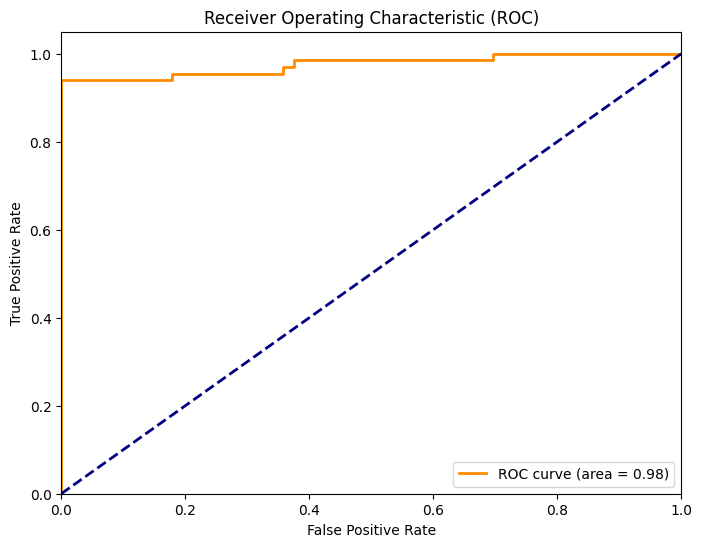

In [9]:
# Generate ROC curve values
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(roc_auc)

# Plotting the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

The ROC curve above demonstrates the model's ability to differentiate between the two classes (demented and non-demented). The area under the curve (AUC) of approximately 0.98 indicates a high level of diagnostic ability.

# Random Forest Visualization #

We will display one of the trees from the forest.

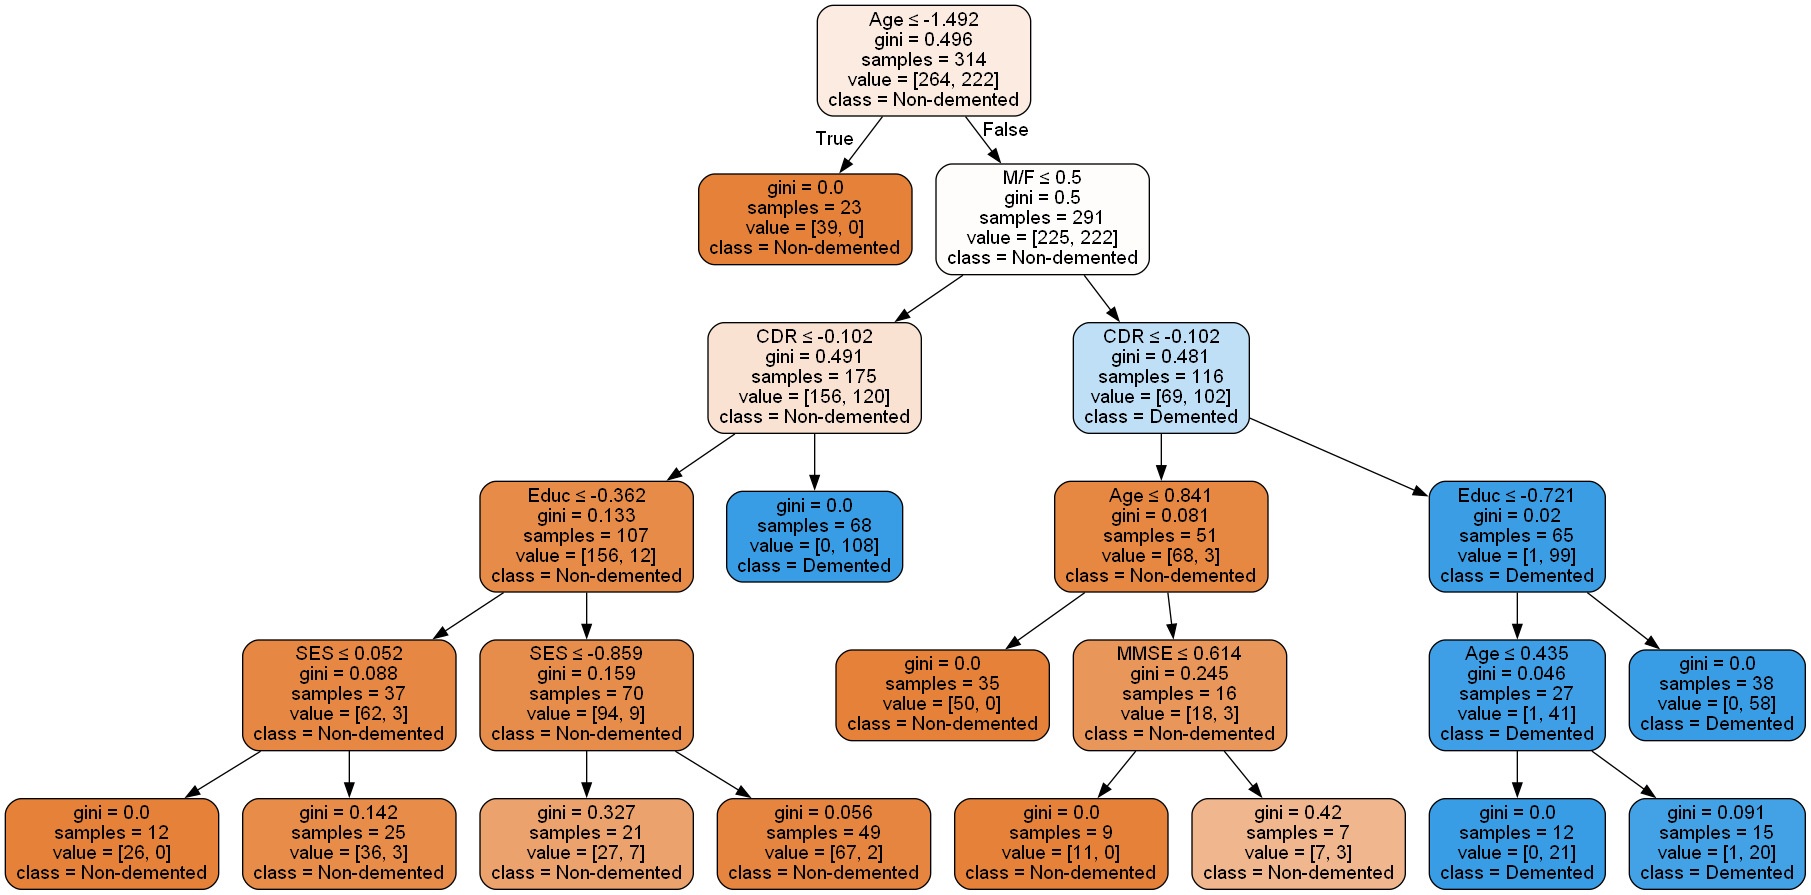

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import graphviz
from IPython.display import display
from IPython.display import Image

# Choose which tree to visualize
# For example, to visualize the first tree
estimator = best_rf.estimators_[20]  # This selects the 21st tree in the forest (0-indexed)

# Export as dot file
dot_data = tree.export_graphviz(estimator, out_file=None, 
                                feature_names=X_train.columns,  
                                class_names=['Non-demented', 'Demented'],  # adjust based on your target classes
                                filled=True, rounded=True,  
                                special_characters=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
path = graph.render("RF_tree_visualization")
display(Image(path))


In [11]:
import time
# Start the timer for the training process
start_time = time.time()

# Fit the model using GridSearchCV
grid_search.fit(X_train, y_train)

# End the training timer and start the prediction timer
train_time = time.time() - start_time
start_time = time.time()

# Predictions on the test set
y_pred = grid_search.best_estimator_.predict(X_test)

# End the prediction timer
predict_time = time.time() - start_time

# Total samples processed (training + testing)
total_samples = len(X_train) + len(X_test)

# Calculate the time per sample
time_per_sample = (train_time + predict_time) / total_samples

print(f"Total training time: {train_time:.4f}s")
print(f"Total prediction time: {predict_time:.4f}s")
print(f"Processing time per sample: {time_per_sample:.4f}s/sample")


Total training time: 290.0868s
Total prediction time: 0.0329s
Processing time per sample: 0.4772s/sample
